# Application: using Piven on yearpredictionMSD dataset

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from piven.regressors import build_keras_piven
from piven.loss import piven_loss
from piven.metrics.tensorflow import mpiw, picp
from piven.metrics.numpy import coverage, pi_width, piven_loss as piven_loss_numpy
from piven.compose import PivenTransformedTargetRegressor
from piven.wrappers import PivenModelWrapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.compose import TransformedTargetRegressor

dpath = Path("data/YearPredictionMSD.txt")

In [2]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [7]:
# As per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

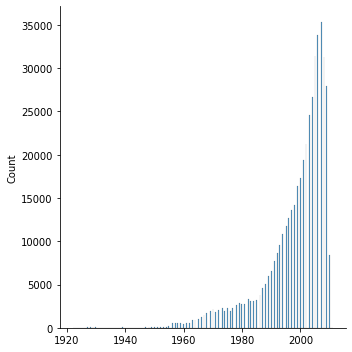

In [8]:
sns.displot(train_y)
plt.show()

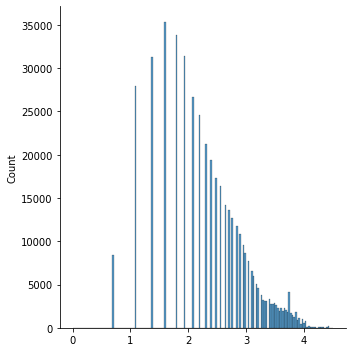

In [9]:
# Transform outcome variable (left-skewed)

max_out_train = np.max(train_y)

def reflect_and_log(x, max_out_train):
    return np.log(1 + max_out_train - train_y)

train_y_transformed = reflect_and_log(train_y, max_out_train)
test_y_transformed = reflect_and_log(test_y, max_out_train)

sns.displot(train_y_transformed)
plt.show()

In [10]:
# Make build function for the model wrapper
def piven_model(input_dim, dense_units, dropout_rate, lambda_=10.0, lr=0.0001):
    model = build_keras_piven(input_dim=input_dim,
                             dense_units=dense_units,
                             dropout_rate=dropout_rate,
                             activation="relu",
                             bias_init_low=-3,
                             bias_init_high=3)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                  loss=piven_loss(lambda_, 160.0, 0.05),
                  metrics=[picp, mpiw])
    return model

In [13]:
# Set up the model using the MLP that comes with piven
# Using best hyperparamter values (see hyperparameter optimization below.)
model = PivenModelWrapper(build_fn=piven_model, 
                          input_dim=train_x.shape[-1], 
                          dense_units=(64,32), 
                          dropout_rate=(0.0,0.0),
                          lambda_=34.75,
                          lr=0.00056)

In [14]:
# Put model in pipeline
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", model)
])

In [15]:
# Finally, normalize the output target
model_ttr = PivenTransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [16]:
# Fit
h = model_ttr.fit(train_x, train_y_transformed, model__epochs=15, model__validation_split=0.2, model__batch_size=64)

Epoch 1/15
5797/5797 [==============================] - 7s 1000us/step - loss: 5.9792 - picp: 0.9357 - mpiw: 4.2281 - val_loss: 5.3647 - val_picp: 0.9357 - val_mpiw: 3.5604
Epoch 2/15
5797/5797 [==============================] - 5s 917us/step - loss: 4.6295 - picp: 0.9413 - mpiw: 3.5650 - val_loss: 5.0541 - val_picp: 0.9452 - val_mpiw: 3.4851
Epoch 3/15
5797/5797 [==============================] - 5s 899us/step - loss: 4.4044 - picp: 0.9432 - mpiw: 3.4111 - val_loss: 5.0712 - val_picp: 0.9401 - val_mpiw: 3.2868
Epoch 4/15
5797/5797 [==============================] - 5s 866us/step - loss: 4.2538 - picp: 0.9434 - mpiw: 3.3171 - val_loss: 5.0472 - val_picp: 0.9339 - val_mpiw: 3.1797
Epoch 5/15
5797/5797 [==============================] - 5s 879us/step - loss: 4.1747 - picp: 0.9432 - mpiw: 3.2464 - val_loss: 5.3381 - val_picp: 0.9217 - val_mpiw: 3.0819
Epoch 6/15
5797/5797 [==============================] - 5s 876us/step - loss: 4.1256 - picp: 0.9423 - mpiw: 3.1996 - val_loss: 4.8234 - val

In [17]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [18]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [19]:
coverage(test_y, y_pi_low_t, y_pi_high_t)

0.9271547549874104

In [21]:
pi_width(y_pi_low_t, y_pi_high_t)

27.810064

In [22]:
df_res = pd.DataFrame({
    "true":test_y,
    "pred":ypred,
    "pi_low":y_pi_low_t,
    "pi_high":y_pi_high_t
})

In [23]:
print(mae(test_y, ypred))
print(np.sqrt(mse(test_y, ypred)))

6.166116094801653
9.52836037908254


In [24]:
col_out = (y_pi_low_t <= test_y) & (test_y <= y_pi_high_t)
colmap = np.array(["green" if cov else "red" for cov in col_out])

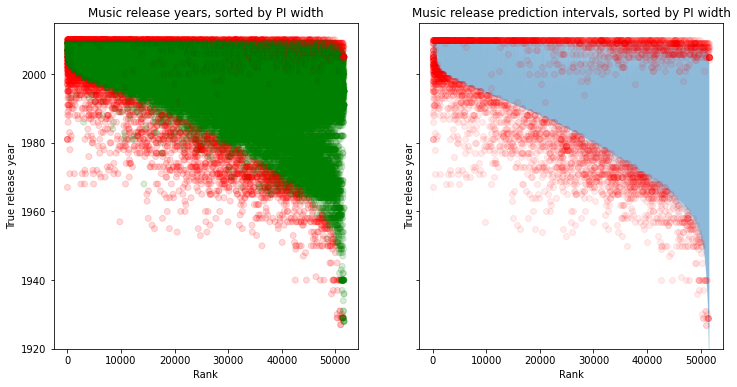

In [25]:
pi_width_sorted_idx = np.argsort(y_pi_high_t - y_pi_low_t)
test_y_sorted = test_y[pi_width_sorted_idx]
colmap_sorted = colmap[pi_width_sorted_idx]

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
ax[0].scatter(range(test_y.shape[0]), test_y_sorted, c=colmap_sorted,alpha=0.15)
ax[0].set_ylim(1920, 2015)
ax[0].set_title("Music release years, sorted by PI width")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("True release year")

pred_wrong = test_y_sorted[colmap_sorted == "red"]
year_wrong = np.array([*range(test_y.shape[0])])[colmap_sorted == "red"]
ax[1].fill_between(
    range(test_y.shape[0]),
    y_pi_low_t[pi_width_sorted_idx],
    y_pi_high_t[pi_width_sorted_idx],
    alpha=0.5
)
ax[1].scatter(year_wrong, pred_wrong, c="r", alpha=0.08)
ax[1].set_ylim(1920, 2015)
ax[1].set_title("Music release prediction intervals, sorted by PI width")
ax[1].set_xlabel("Rank")
ax[1].set_ylabel("True release year")

plt.show()

In [26]:
outliers = df_res[df_res.true < 1960]
coverage(outliers.true, outliers.pi_low, outliers.pi_high)

outliers.head(10)

/opt/anaconda3/envs/pivenregressor/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,true,pred,pi_low,pi_high
70,1940,1994.747314,1946.276001,2007.446899
72,1940,1995.177490,1954.750854,2007.786377
73,1940,1993.098267,1958.218506,2005.813110
922,1945,1994.706665,1951.013062,2008.144775
923,1945,1979.849731,1947.185181,1999.360962
924,1945,1985.307861,1951.318359,2002.747437
1006,1959,1999.911377,1963.854980,2009.129517
1009,1959,1993.379883,1948.362427,2008.182983
1010,1959,1995.818848,1957.905640,2008.063599
1011,1959,2002.750732,1974.422974,2009.172119


In [28]:
pi_width(outliers.pi_low, outliers.pi_high)

54.934155

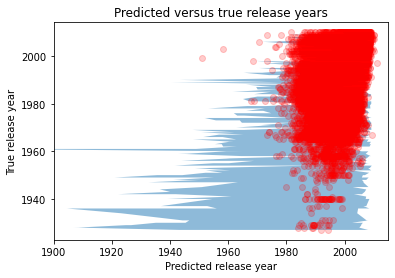

In [29]:
idx_sort = np.argsort(test_y)
plt.fill_betweenx(
    test_y[idx_sort],
    y_pi_low_t[idx_sort],
    y_pi_high_t[idx_sort],
    alpha=0.5
)
plt.scatter(ypred[idx_sort], test_y[idx_sort], c="r", alpha=0.2)
plt.xlim(1900, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()

The PI are getting smaller as the true release year gets closer to 2012. This makes sense as the bulk of the data is there.

## With a regular MLP

In [30]:
def mlp_model(input_dim):    
    i = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(i)
    x = tf.keras.layers.Dense(
        32,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    o = tf.keras.layers.Dense(
        1,
        activation="relu",
    )(x)
    model = tf.keras.models.Model(inputs=i, outputs=[o], name="MLP")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss="mse")
    return model
mlp = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=mlp_model,
    input_dim=train_x.shape[-1]
)
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", mlp)
])
mlp_ttr = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [31]:
mlp_ttr.fit(train_x, train_y_transformed, model__epochs=10, model__validation_split=0.2, model__batch_size=64)

Epoch 1/10
5797/5797 [==============================] - 4s 731us/step - loss: 0.9659 - val_loss: 0.8528
Epoch 2/10
5797/5797 [==============================] - 4s 699us/step - loss: 0.8331 - val_loss: 0.8290
Epoch 3/10
5797/5797 [==============================] - 4s 717us/step - loss: 0.8171 - val_loss: 0.8174
Epoch 4/10
5797/5797 [==============================] - 4s 681us/step - loss: 0.8085 - val_loss: 0.8113
Epoch 5/10
5797/5797 [==============================] - 4s 676us/step - loss: 0.7986 - val_loss: 0.8083
Epoch 6/10
5797/5797 [==============================] - 4s 677us/step - loss: 0.7957 - val_loss: 0.8060
Epoch 7/10
5797/5797 [==============================] - 4s 683us/step - loss: 0.7904 - val_loss: 0.8046
Epoch 8/10
5797/5797 [==============================] - 4s 695us/step - loss: 0.7870 - val_loss: 0.8029
Epoch 9/10
5797/5797 [==============================] - 4s 691us/step - loss: 0.7896 - val_loss: 0.8018
Epoch 10/10
5797/5797 [==============================] - 4s 712u

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      StandardScaler()),
                                                     ('model',
                                                      <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f8db5285250>)]),
                           transformer=StandardScaler())

In [32]:
ypred_mlp = mlp_ttr.predict(test_x)
ypred_mlp = back_transform(ypred_mlp, max_out_train)

In [33]:
print(mae(test_y, ypred_mlp))
print(np.sqrt(mse(test_y, ypred_mlp)))

6.48313838021136
9.371618730895042


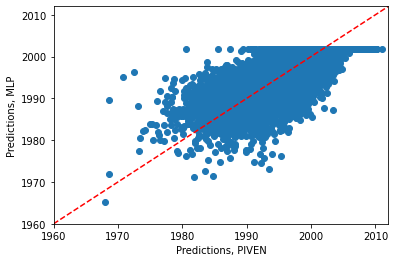

In [34]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2012)
plt.ylim(1960, 2012)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.plot(range(1960, 2015), range(1960, 2015), '--', c="r")
plt.show()

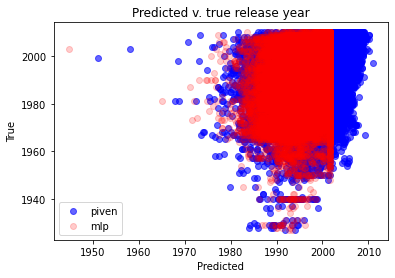

In [35]:
plt.scatter(ypred, test_y, c="b", alpha=0.6, label="piven")
plt.scatter(ypred_mlp, test_y, c="r", alpha=0.2, label="mlp")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.legend()
plt.title("Predicted v. true release year")
plt.show()

In [12]:
lambda_ = 10.0
lr = 0.0001
seed = 2525


In [13]:
# Split train from test data
x_ind = [*range(train_x.shape[0])]
np.random.shuffle(x_ind)
train_x_trial, val_x_trial = train_x[:420000, :].copy(), train_x[420000:, :].copy()
train_y_trial, val_y_trial = train_y[:420000].copy(), train_y[420000:].copy()
max_train_out = np.max(train_y_trial)
# Transform
train_y_trial_transformed = reflect_and_log(train_y_trial, max_train_out)
val_y_trial_transformed = reflect_and_log(val_y_trial, max_train_out)
# Instantiate model
model = PivenModelWrapper(build_fn=piven_model, 
                          input_dim=train_x_trial.shape[-1], 
                          dense_units=(64,32), 
                          dropout_rate=(0.0,0.0),
                          lambda_=lambda_,
                          lr=lr)
# Put model in pipeline
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", model)
])
model_ttr = PivenTransformedTargetRegressor(regressor=pipeline,
                                        transformer=StandardScaler())
# Fit
model_ttr.fit(train_x_trial, train_y_trial_transformed, model__epochs=5, 
              model__validation_split=0.2, model__batch_size=64,
              model__verbose=True)
y_pred, y_pred_pi_low, y_pred_pi_high = model_ttr.predict(val_x_trial, return_prediction_intervals=True)
# Back-transform the predictions and PIs

y_pred = back_transform(y_pred, max_train_out)
y_pi_low = back_transform(y_pred_pi_high, max_train_out)
y_pi_high = back_transform(y_pred_pi_low, max_train_out)
# Compute metrics
cov_trial = coverage(val_y_trial, y_pi_low, y_pi_high)
piw_trial = pi_width(y_pi_low, y_pi_high)
loss_trial = piven_loss_numpy(val_y_trial, y_pred, y_pi_low, y_pi_high, 10.0, 160.0, 0.05)

Epoch 1/5
5250/5250 [==============================] - 6s 908us/step - loss: 8.4641 - picp: 0.8780 - mpiw: 4.4198 - val_loss: 5.7508 - val_picp: 0.8864 - val_mpiw: 3.5825
Epoch 2/5
5250/5250 [==============================] - 5s 895us/step - loss: 5.1519 - picp: 0.8986 - mpiw: 3.5844 - val_loss: 5.1356 - val_picp: 0.9083 - val_mpiw: 3.5168
Epoch 3/5
5250/5250 [==============================] - 5s 863us/step - loss: 4.7312 - picp: 0.9047 - mpiw: 3.4193 - val_loss: 4.9329 - val_picp: 0.8982 - val_mpiw: 3.2732
Epoch 4/5
5250/5250 [==============================] - 5s 872us/step - loss: 4.5211 - picp: 0.9026 - mpiw: 3.2644 - val_loss: 4.7723 - val_picp: 0.9016 - val_mpiw: 3.2095
Epoch 5/5
5250/5250 [==============================] - 4s 851us/step - loss: 4.3701 - picp: 0.9045 - mpiw: 3.1895 - val_loss: 4.6210 - val_picp: 0.9110 - val_mpiw: 3.2145


PivenTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                           StandardScaler()),
                                                          ('model',
                                                           <piven.wrappers.PivenModelWrapper object at 0x7f7f38b650d0>)]),
                                transformer=StandardScaler())

In [14]:
y_pred, y_pred_pi_low, y_pred_pi_high = model_ttr.predict(val_x_trial, return_prediction_intervals=True)

In [15]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
y_pred = back_transform(y_pred, max_train_out)
y_pi_low = back_transform(y_pred_pi_high, max_train_out)
y_pi_high = back_transform(y_pred_pi_low, max_train_out)

In [17]:
cov_trial = coverage(val_y_trial, y_pi_low, y_pi_high)
piw_trial = pi_width(y_pi_low, y_pi_high)
loss_trial = piven_loss_numpy(val_y_trial, y_pred, y_pi_low, y_pi_high, 10.0, 160.0, 0.05)

In [20]:
piw_trial

33.11132

## Hyperparameter optimization

In [35]:
import optuna


def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp


def objective(trial: optuna.trial.Trial):
    lambda_ = trial.suggest_float("lambda_", 1.0, 35.0)
    lr = trial.suggest_loguniform("lr", 1e-5, 0.001)
    seed = trial.suggest_int("seed", 162, 9999999)
    np.random.seed(seed)
    # Split train from test data
    x_ind = [*range(train_x.shape[0])]
    np.random.shuffle(x_ind)
    train_x_trial, val_x_trial = train_x[:420000, :].copy(), train_x[420000:, :].copy()
    train_y_trial, val_y_trial = train_y[:420000].copy(), train_y[420000:].copy()
    max_train_out = np.max(train_y_trial)
    # Transform
    train_y_trial_transformed = reflect_and_log(train_y_trial, max_train_out)
    val_y_trial_transformed = reflect_and_log(val_y_trial, max_train_out)
    # Instantiate model
    model = PivenModelWrapper(build_fn=piven_model, 
                              input_dim=train_x_trial.shape[-1], 
                              dense_units=(64,32), 
                              dropout_rate=(0.0,0.0),
                              lambda_=lambda_,
                              lr=lr)
    # Put model in pipeline
    pipeline = Pipeline([
        ("preprocess", StandardScaler()),
        ("model", model)
    ])
    model_ttr = PivenTransformedTargetRegressor(regressor=pipeline,
                                            transformer=StandardScaler())
    # Fit
    model_ttr.fit(train_x_trial, train_y_trial_transformed, model__epochs=15, 
                  model__validation_split=0.1, model__batch_size=64,
                  model__verbose=False)
    y_pred, y_pred_pi_low, y_pred_pi_high = model_ttr.predict(val_x_trial, return_prediction_intervals=True)
    # Back-transform the predictions and PIs
    y_pred = back_transform(y_pred, max_train_out)
    y_pi_low = back_transform(y_pred_pi_high, max_train_out)
    y_pi_high = back_transform(y_pred_pi_low, max_train_out)
    # Compute metrics
    cov_trial = coverage(val_y_trial, y_pi_low, y_pi_high)
    piw_trial = pi_width(y_pi_low, y_pi_high)
    loss_trial = piven_loss_numpy(val_y_trial, y_pred, y_pi_low, y_pi_high, lambda_, 160.0, 0.05)
    # Set metrics
    trial.set_user_attr("coverage", float(cov_trial))
    trial.set_user_attr("pi_width", float(piw_trial))
    # Return model loss
    return float(loss_trial)

In [36]:
experiment = optuna.create_study(direction="minimize",
                                 study_name="piven_year_msd",
                                 storage='sqlite:///data/experiment_results.db',
                                 load_if_exists=True)

[I 2020-12-26 12:55:28,895] A new study created in RDB with name: piven_year_msd


In [ ]:
experiment.optimize(objective, n_trials=25)